# Training an Attention Model on Tensorflow Datasets
## Prerequisites

In [27]:
import json
import math
import os
from typing import Any, Callable, Dict, List, Optional, Tuple, Union

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from IPython.core.display import display
from mmproteo.utils import log, paths, utils, visualization
from mmproteo.utils.formats.tf_dataset import DatasetLoader
from mmproteo.utils.ml import callbacks, evaluation
from official.modeling import tf_utils
from official.nlp.modeling.models.seq2seq_transformer import Seq2SeqTransformer, TransformerDecoder, TransformerEncoder
from official.nlp.modeling.ops import beam_search

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="7"

In [4]:
#tf.debugging.set_log_device_placement(True)
GPUs = tf.config.list_physical_devices('GPU')
GPUs

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

## Configuration

In [5]:
!pwd

/hpi/fs00/home/mirko.krause/masterthesis/pride-downloader/notebooks


In [6]:
if os.getcwd() == "/tf":
    os.chdir(os.path.join('workspace', 'notebooks'))

In [7]:
!pwd

/hpi/fs00/home/mirko.krause/masterthesis/pride-downloader/notebooks


In [8]:
DUMP_PATH = "/scratch/mirko.krause/pdeep"
TRAINING_COLUMNS_DUMP_PATH = os.path.join(DUMP_PATH, "training_columns")
FILES_PATH = os.path.join(TRAINING_COLUMNS_DUMP_PATH, "file_*.parquet")

In [9]:
print(f"dump path = {DUMP_PATH}")
THREAD_COUNT = min(int(os.cpu_count()/2), 16)
STATISTICS_FILE_PATH = os.path.join(TRAINING_COLUMNS_DUMP_PATH, "statistics.parquet")
DATASET_DUMP_PATH = os.path.join(TRAINING_COLUMNS_DUMP_PATH, "tf_datasets")
PROCESSING_FILE_PATH = os.path.join(DATASET_DUMP_PATH, "processing_info.json")

dump path = /scratch/mirko.krause/pdeep


In [10]:
SEQ = 'peptide_sequence'

In [11]:
logger = log.create_logger(
    name='mmproteo_attention_model',
    verbose=True,
    log_dir=DUMP_PATH,
)

2021-08-10 12:17:59,627 - mmproteo_attention_model: Logging to file '/scratch/mirko.krause/pdeep/mmproteo_attention_model.log' and to stderr


In [79]:
with open(PROCESSING_FILE_PATH, 'r') as file:
    PROCESSING_INFO = json.loads(file.read())
PROCESSING_INFO

{'padding_characters': {'peptide_sequence': '_',
  'mz_array': 0.0,
  'intensity_array': 0.0},
 'padding_lengths': {'mz_array': 89,
  'intensity_array': 89,
  'peptide_sequence': 30},
 'idx_to_char': {'0': 'A',
  '1': 'C',
  '2': 'D',
  '3': 'E',
  '4': 'F',
  '5': 'G',
  '6': 'H',
  '7': 'I',
  '8': 'K',
  '9': 'L',
  '10': 'M',
  '11': 'N',
  '12': 'P',
  '13': 'Q',
  '14': 'R',
  '15': 'S',
  '16': 'T',
  '17': 'V',
  '18': 'W',
  '19': 'Y',
  '20': '_'},
 'normalization': {'intensity_array': '<function base_peak_normalize at 0x7f9e3ee96af0>'},
 'split_value_columns': None,
 'training_data_columns': ['mz_array', 'intensity_array'],
 'target_data_columns': ['peptide_sequence'],
 'element_spec': '((TensorSpec(shape=(89,), dtype=tf.float64, name=None), TensorSpec(shape=(89,), dtype=tf.float64, name=None)), (TensorSpec(shape=(30,), dtype=tf.int8, name=None),))'}

In [80]:
def find_grouping_path_position(cols: Optional[List[str]], prefered_item: str, alternative_index: int = -1) -> int:
    res = alternative_index
    if cols is not None:
        try:
            res = cols.index(prefered_item) - len(cols)
        except ValueError:
            pass
    return res

In [81]:
grouping_path_position = find_grouping_path_position(
    cols=PROCESSING_INFO['split_value_columns'],
    prefered_item='species',
    alternative_index=-1,
)
grouping_path_position

-1

In [82]:
idx_to_char = {int(idx): char for idx, char in PROCESSING_INFO["idx_to_char"].items()}
idx_to_char[-1] = "[start]"
char_to_idx = {char: idx for idx, char in idx_to_char.items()}

## Loading Tensorflow Datasets

In [83]:
KEEP_CACHE = False

In [84]:
BATCH_SIZE = 512

In [85]:
TRAINING_TYPE = 'Train'
TEST_TYPE = 'Test'
EVAL_TYPE = 'Eval'

In [86]:
dataset_file_paths = paths.assign_wildcard_paths_to_splits_grouped_by_path_position_value(
    wildcard_path = os.path.join(
        DATASET_DUMP_PATH, 
        '*.parquet',  # filename
        *(PROCESSING_INFO['split_value_columns'] or [])
    ),
    path_position = grouping_path_position,
    splits = {
            TRAINING_TYPE: 0.8,
            TEST_TYPE: 0.9,
            EVAL_TYPE: 1.0
        },
    paths_dump_file = os.path.join(
            DATASET_DUMP_PATH,
            "dataset_file_paths.json"
        ),
    skip_existing = KEEP_CACHE,
    logger = logger
)

print()
print("assigned dataset files:")
visualization.print_list_length_in_dict(dataset_file_paths)


assigned dataset files:
#Train = 20
e.g.: /scratch/mirko.krause/pdeep/training_columns/tf_datasets/file_6.parquet
#Test = 3
e.g.: /scratch/mirko.krause/pdeep/training_columns/tf_datasets/file_2.parquet
#Eval = 3
e.g.: /scratch/mirko.krause/pdeep/training_columns/tf_datasets/file_24.parquet


2021-08-10 13:49:08,716 - mmproteo_attention_model: DEBUG: assigned values:
2021-08-10 13:49:08,717 - mmproteo_attention_model: DEBUG: #Train = 20
2021-08-10 13:49:08,717 - mmproteo_attention_model: DEBUG: e.g.: file_6.parquet
2021-08-10 13:49:08,717 - mmproteo_attention_model: DEBUG: #Test = 3
2021-08-10 13:49:08,717 - mmproteo_attention_model: DEBUG: e.g.: file_2.parquet
2021-08-10 13:49:08,717 - mmproteo_attention_model: DEBUG: #Eval = 3
2021-08-10 13:49:08,717 - mmproteo_attention_model: DEBUG: e.g.: file_24.parquet
2021-08-10 13:49:08,718 - mmproteo_attention_model: DEBUG: assigned paths:
2021-08-10 13:49:08,718 - mmproteo_attention_model: DEBUG: #Train = 20
2021-08-10 13:49:08,718 - mmproteo_attention_model: DEBUG: e.g.: /scratch/mirko.krause/pdeep/training_columns/tf_datasets/file_6.parquet
2021-08-10 13:49:08,718 - mmproteo_attention_model: DEBUG: #Test = 3
2021-08-10 13:49:08,718 - mmproteo_attention_model: DEBUG: e.g.: /scratch/mirko.krause/pdeep/training_columns/tf_datasets/

### Loading corresponding TF datasets

In [87]:
element_spec = eval(PROCESSING_INFO['element_spec'], {}, {'TensorSpec':tf.TensorSpec, 'tf':tf})
element_spec

((TensorSpec(shape=(89,), dtype=tf.float64, name=None),
  TensorSpec(shape=(89,), dtype=tf.float64, name=None)),
 (TensorSpec(shape=(30,), dtype=tf.int8, name=None),))

**In the following step, Tensorflow starts allocating a GPU**

In [88]:
# initialize Tensorflow (might take several minutes (~5 minutes per GPU with 40GB VRAM each))
logger.debug("started initializing tensorflow by creating a first dataset")
tf.data.Dataset.range(5)
logger.info("finished initializing tensorflow")

2021-08-10 13:49:09,462 - mmproteo_attention_model: DEBUG: started initializing tensorflow by creating a first dataset
2021-08-10 13:49:09,463 - mmproteo_attention_model: finished initializing tensorflow


In [89]:
ds_options = tf.data.Options()
ds_options.experimental_threading.private_threadpool_size = THREAD_COUNT
ds_options.experimental_threading.max_intra_op_parallelism = THREAD_COUNT

In [90]:
datasets = DatasetLoader(
    element_spec=element_spec,
    batch_size=BATCH_SIZE,
    shuffle_buffer_size=100_000,
    thread_count=min(int(os.cpu_count()/4), 4),
    keep_cache=KEEP_CACHE,
    logger=logger,
    run_benchmarks=False,
    options=ds_options,
).load_datasets_by_type(dataset_file_paths)
datasets

2021-08-10 13:49:09,769 - mmproteo_attention_model: DEBUG: preparing dataset 'Train' with 20 paths
2021-08-10 13:49:09,770 - mmproteo_attention_model: DEBUG: applied options to dataset 'Train'
2021-08-10 13:49:09,779 - mmproteo_attention_model: DEBUG: loaded dataset 'Train' interleaved
2021-08-10 13:49:09,779 - mmproteo_attention_model: DEBUG: shuffled dataset 'Train'
2021-08-10 13:49:09,780 - mmproteo_attention_model: DEBUG: batched dataset 'Train'
2021-08-10 13:49:09,780 - mmproteo_attention_model: DEBUG: skipped caching dataset 'Train'
2021-08-10 13:49:09,780 - mmproteo_attention_model: DEBUG: configured prefetching for dataset 'Train'
2021-08-10 13:49:09,780 - mmproteo_attention_model: DEBUG: skipped benchmarking dataset 'Train'
2021-08-10 13:49:09,780 - mmproteo_attention_model: prepared dataset 'Train'
2021-08-10 13:49:09,781 - mmproteo_attention_model: DEBUG: preparing dataset 'Test' with 3 paths
2021-08-10 13:49:09,781 - mmproteo_attention_model: DEBUG: applied options to datas

{'Train': <PrefetchDataset shapes: (((512, 89), (512, 89)), ((512, 30),)), types: ((tf.float64, tf.float64), (tf.int8,))>,
 'Test': <PrefetchDataset shapes: (((512, 89), (512, 89)), ((512, 30),)), types: ((tf.float64, tf.float64), (tf.int8,))>,
 'Eval': <PrefetchDataset shapes: (((512, 89), (512, 89)), ((512, 30),)), types: ((tf.float64, tf.float64), (tf.int8,))>}

In [91]:
original_datasets = datasets

In [92]:
def prefix_target_sequences_with_start_token(tensor: tf.Tensor, token: Any = char_to_idx["[start]"]) -> tf.Tensor:
    return tf.concat(
        values=[
            tf.broadcast_to(
                input=tf.constant(token, dtype=tensor.dtype),
                shape=(
                    tensor.shape[0],  # batch dimension
                    1
                )
            ),
            tensor
        ],
        axis=1
    )


def _dataset_mapper_for_transformer(trainings: Tuple[tf.Tensor], targets: Tuple[tf.Tensor]) \
-> Tuple[Dict[str, tf.data.Dataset], tf.data.Dataset]:
    inputs = tf.stack(trainings, axis=-1)[:, :500, :]  # cut off too long spectra
    inputs = tf.cast(x=inputs, dtype=tf.float32)
    targets = prefix_target_sequences_with_start_token(targets[0])
    targets = tf.cast(
        x=targets,
        dtype=tf.int32,
    )

    return (
        {
            "inputs": inputs,
            "targets": targets[:, :-1],
        },
        targets[:, 1:]
    )


def prepare_dataset_for_transformer_training(dataset: tf.data.Dataset) -> tf.data.Dataset:
    return dataset.map(_dataset_mapper_for_transformer)

In [93]:
# use these methods if the model shifts the target input itself

def _dataset_mapper_for_transformer_unshifted(trainings: Tuple[tf.Tensor], targets: Tuple[tf.Tensor]) \
-> Tuple[Dict[str, tf.data.Dataset], tf.data.Dataset]:
    inputs = tf.stack(trainings, axis=-1)[:, :500, :]  # cut off too long spectra
    inputs = tf.cast(x=inputs, dtype=tf.float32)

    targets = tf.cast(
        x=targets[0],
        dtype=tf.int32,
    )

    return (
        {
            "inputs": inputs,
            "targets": targets,
        },
        targets
    )

def prepare_dataset_for_transformer_training_unshifted(dataset: tf.data.Dataset) -> tf.data.Dataset:
    return dataset.map(_dataset_mapper_for_transformer_unshifted)

In [94]:
datasets = {
    t: prepare_dataset_for_transformer_training_unshifted(dataset) for t, dataset in original_datasets.items()
}
datasets

{'Train': <MapDataset shapes: ({inputs: (512, 89, 2), targets: (512, 30)}, (512, 30)), types: ({inputs: tf.float32, targets: tf.int32}, tf.int32)>,
 'Test': <MapDataset shapes: ({inputs: (512, 89, 2), targets: (512, 30)}, (512, 30)), types: ({inputs: tf.float32, targets: tf.int32}, tf.int32)>,
 'Eval': <MapDataset shapes: ({inputs: (512, 89, 2), targets: (512, 30)}, (512, 30)), types: ({inputs: tf.float32, targets: tf.int32}, tf.int32)>}

In [95]:
print("original datasets:")
display(tfds.benchmark(original_datasets[TEST_TYPE]))

print()

print("mapped datasets:")
display(tfds.benchmark(datasets[TEST_TYPE]))

original datasets:


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 235.51 ex/sec (total: 5856 ex, 24.87 sec)
Examples/sec (First only) 1.63 ex/sec (total: 1 ex, 0.61 sec)
Examples/sec (First excluded) 241.42 ex/sec (total: 5855 ex, 24.25 sec)


,duration,num_examples,avg
first+lasts,24.865122,5856,235.510609
first,0.612754,1,1.631975
lasts,24.252367,5855,241.419730



mapped datasets:


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 278.37 ex/sec (total: 5856 ex, 21.04 sec)
Examples/sec (First only) 1.80 ex/sec (total: 1 ex, 0.56 sec)
Examples/sec (First excluded) 285.87 ex/sec (total: 5855 ex, 20.48 sec)


,duration,num_examples,avg
first+lasts,21.036540,5856,278.372774
first,0.555364,1,1.800622
lasts,20.481176,5855,285.872250


## Building the Tensorflow Model

In [96]:
# taken from: https://github.com/tensorflow/models/blob/027813d334645d6076a72b41b7b87ec30334cbb1/official/nlp/modeling/layers/position_embedding.py#L91
def embed_with_sin_and_cos(positions: Union[tf.Tensor, np.ndarray], embedding_width: int) -> tf.Tensor:
    """
    positions: a tensor with the dimensions [batch_size, item count]
    """
    # constants
    num_timescales = embedding_width // 2
    min_timescale, max_timescale = 1.0, 1.0e4
    log_timescale_increment = (
        math.log(float(max_timescale) / float(min_timescale)) /
        (tf.cast(num_timescales, tf.float32) - 1))
    inv_timescales = min_timescale * tf.exp(
        tf.cast(tf.range(num_timescales), tf.float32) *
        -log_timescale_increment)

    # calculations
    scaled_time = tf.expand_dims(positions, -1) * tf.expand_dims(
        inv_timescales, 0)
    position_embeddings = tf.concat(
        [tf.sin(scaled_time), tf.cos(scaled_time)], axis=-1)
    return position_embeddings

In [97]:
# heavily based on:
# https://github.com/tensorflow/models/blob/061c58a3937953c79819fd4e8826af1570cb6024/official/nlp/transformer/transformer.py
# (29.06.2021)
class MyTransformer(Seq2SeqTransformer):
    def call(self, inputs):
        """Calculate target logits or inferred target sequences.
        Args:
          inputs: a dictionary of tensors.
            Feature `inputs`: int tensor with shape `[batch_size, input_length]`.
            Feature `targets` (optional): None or int tensor with shape
              `[batch_size, target_length]`.
        Returns:
          If targets is defined, then return logits for each word in the target
          sequence, which is a float tensor with shape
          `(batch_size, target_length, vocab_size)`. If target is `None`, then
          generate output sequence one token at a time and
          returns a dictionary {
              outputs: `(batch_size, decoded_length)`
              scores: `(batch_size, 1)`}
          Even when `float16` is used, the output tensor(s) are always `float32`.
        Raises:
          NotImplementedError: If try to use padded decode method on CPU/GPUs.
        """
        sources = inputs["inputs"]
        mz = sources[:, :, 0]
        intensities = sources[:, :, 1]
        targets = inputs.get("targets", None)
        
        # Prepare inputs to the layer stack by adding positional encodings and applying dropout.

        embedded_mz = embed_with_sin_and_cos(mz, self._embedding_width)
        embedded_intensities = embedded_mz * tf.expand_dims(intensities, -1)
    
        sources = embedded_intensities
        
        # Attention_mask generation.
        input_shape = tf_utils.get_shape_list(sources, expected_rank=3)
        batch_size = input_shape[0]
        input_length = input_shape[1]
        channel_count = input_shape[2]
        non_padding_sources = tf.not_equal(mz, 0.0)
        non_padding_sources = tf.reshape(
            tensor=non_padding_sources,
            shape=[batch_size, 1, input_length]
        )
        attention_mask = tf.cast(
            x=non_padding_sources,
            dtype=sources.dtype
        )
        broadcast_ones = tf.ones(
            shape=[batch_size, input_length, 1],
            dtype=sources.dtype
        )
        attention_mask = broadcast_ones * attention_mask

        encoder_inputs = self.encoder_dropout(sources)

        encoder_outputs = self.encoder_layer(
            encoder_inputs, attention_mask=attention_mask)
        
        if targets is None:
            if self._padded_decode:
                max_decode_length = self._decode_max_length
            else:
                max_decode_length = self._decode_max_length or (
                        tf.shape(encoder_outputs)[1] + self._extra_decode_length)
            symbols_to_logits_fn = self._get_symbols_to_logits_fn(max_decode_length)

            batch_size = tf.shape(encoder_outputs)[0]
            # Create initial set of IDs that will be passed to symbols_to_logits_fn.
            initial_ids = tf.zeros([batch_size], dtype=tf.int32)

            # Create cache storing decoder attention values for each layer.
            init_decode_length = (max_decode_length if self._padded_decode else 0)
            num_heads = self.decoder_layer.num_attention_heads
            dim_per_head = self._embedding_width // num_heads

            # Cache dtype needs to match beam_search dtype.
            # pylint: disable=g-complex-comprehension
            cache = {
                str(layer): {
                    "key":
                        tf.zeros(
                            [batch_size, init_decode_length, num_heads, dim_per_head],
                            dtype=self.compute_dtype),
                    "value":
                        tf.zeros(
                            [batch_size, init_decode_length, num_heads, dim_per_head],
                            dtype=self.compute_dtype)
                } for layer in range(self.decoder_layer.num_layers)
            }
            # pylint: enable=g-complex-comprehension

            # Add encoder output and attention bias to the cache.
            encoder_outputs = tf.cast(encoder_outputs, dtype=self.compute_dtype)
            attention_mask = tf.cast(
                tf.reshape(
                    tf.not_equal(sources, 0), [input_shape[0], 1, input_shape[1]]),
                dtype=self.compute_dtype)
            cache["encoder_outputs"] = encoder_outputs
            cache["encoder_decoder_attention_mask"] = attention_mask

            # Use beam search to find the top beam_size sequences and scores.
            decoded_ids, scores = beam_search.sequence_beam_search(
                symbols_to_logits_fn=symbols_to_logits_fn,
                initial_ids=initial_ids,
                initial_cache=cache,
                vocab_size=self._vocab_size,
                beam_size=self._beam_size,
                alpha=self._alpha,
                max_decode_length=max_decode_length,
                eos_id=self._eos_id,
                padded_decode=self._padded_decode,
                dtype=self.compute_dtype)

            # Get the top sequence for each batch element
            top_decoded_ids = decoded_ids[:, 0, 1:]
            top_scores = scores[:, 0]

            return {"outputs": top_decoded_ids, "scores": top_scores}

        decoder_inputs = self.embedding_lookup(targets)
        embedding_mask = tf.cast(tf.not_equal(targets, 0), decoder_inputs.dtype)
        decoder_inputs *= tf.expand_dims(embedding_mask, -1)
        # Shift targets to the right, and remove the last element
        # seems smarter than the dataset approach
        decoder_inputs = tf.pad(decoder_inputs, [[0, 0], [1, 0], [0, 0]])[:, :-1, :]
        
        length = tf.shape(decoder_inputs)[1]
        pos_encoding = self.position_embedding(decoder_inputs)
        pos_encoding = tf.cast(pos_encoding, decoder_inputs.dtype)
        decoder_inputs += pos_encoding

        decoder_inputs = self.decoder_dropout(decoder_inputs)

        decoder_shape = tf_utils.get_shape_list(decoder_inputs, expected_rank=3)
        batch_size = decoder_shape[0]
        decoder_length = decoder_shape[1]

        self_attention_mask = tf.linalg.band_part(tf.ones([length, length]), -1, 0)
        self_attention_mask = tf.reshape(self_attention_mask, [1, length, length])
        self_attention_mask = tf.tile(self_attention_mask, [batch_size, 1, 1])

        attention_mask = tf.cast(
            tf.expand_dims(tf.not_equal(sources[:, :, 0], 0), axis=1), dtype=sources.dtype)
        attention_mask = tf.tile(attention_mask, [1, decoder_length, 1])

        outputs = self.decoder_layer(
            decoder_inputs,
            encoder_outputs,
            memory_mask=self_attention_mask,
            target_mask=attention_mask)
        
        logits = self._embedding_linear(self.embedding_lookup.embeddings, outputs)
        # Model outputs should be float32 to avoid numeric issues.
        # https://www.tensorflow.org/guide/mixed_precision#building_the_model
        logits = tf.cast(logits, tf.float32)
        return logits

In [98]:
TRANSFORMER_LAYERS = 6
ATTENTION_HEADS = 16
EMBEDDING_WIDTH = 512  # d_model
LEARNING_RATE = 10**-5

In [99]:
def build_model() -> tf.keras.Model:
    encoder_layer = TransformerEncoder(
        num_attention_heads=ATTENTION_HEADS,
        num_layers=TRANSFORMER_LAYERS,
    )
    decoder_layer = TransformerDecoder(
        num_attention_heads=ATTENTION_HEADS,
        num_layers=TRANSFORMER_LAYERS,
    )

    model = MyTransformer(
        vocab_size=len(idx_to_char),
        embedding_width=EMBEDDING_WIDTH,
        encoder_layer=encoder_layer,
        decoder_layer=decoder_layer,
        name=f"mmproteo_transformer_{utils.get_current_time_str()}",
        decode_max_length=PROCESSING_INFO['padding_lengths'][SEQ],
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=LEARNING_RATE,
            beta_2=0.98,  # values taken from the 'Attention is all you need' paper
            epsilon=10**-9,
        ),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  #masked_loss,
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy()
        ]
    )
    return model

In [100]:
mirrored_strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [101]:
MODELS_PATH = os.path.join(DUMP_PATH, "models")

In [102]:
def create_model() -> tf.keras.Model:
    with mirrored_strategy.scope():
        model = build_model()
    global MODEL_PATH
    MODEL_PATH = os.path.join(MODELS_PATH, model.name)
    utils.ensure_dir_exists(MODEL_PATH)
    logger.info(f"created new model '{model.name}'")
    return model

In [103]:
model = create_model()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2021-08-10 13:49:56,538 - mmproteo_attention_model: created new model 'mmproteo_transformer_20210810-134956'


In [104]:
logger.debug("started a first prediction")
model.predict(datasets[EVAL_TYPE].unbatch().batch(1).take(1))

2021-08-10 13:49:56,542 - mmproteo_attention_model: DEBUG: started a first prediction


array([[[ 4.49295938e-01, -1.56888187e+00, -7.87911177e-01,
          1.81329668e-01,  4.11429435e-01,  8.85580957e-01,
         -2.19438672e-02,  4.45019394e-01, -4.27644551e-02,
         -9.47383642e-01, -5.24107337e-01,  2.59166420e-01,
         -1.98218715e+00,  3.82923067e-01,  2.09817886e-02,
         -3.16279143e-01, -3.54437023e-01,  3.08702409e-01,
         -2.09677267e+00, -1.03829622e+00,  1.04978085e+00,
          1.19677806e+00],
        [ 5.63568115e-01, -1.70776534e+00, -1.13910687e+00,
          3.00651014e-01,  8.47016335e-01,  5.99872947e-01,
         -1.31852984e-01,  6.19188356e+00,  1.93903685e-01,
         -3.61710399e-01, -4.98098761e-01, -3.81364524e-01,
         -1.41345716e+00,  1.11013651e+00, -1.72112107e-01,
         -2.66945362e-03, -1.09568566e-01,  3.12553495e-01,
         -1.97123623e+00, -1.18443108e+00,  1.42999256e+00,
          6.20981336e-01],
        [ 6.06073976e-01, -1.83326590e+00, -3.12763900e-01,
          1.04864597e-01,  1.26028538e+00,  9.

In [105]:
logger.info("finished a first prediction - Tensorflow should be ready now")

2021-08-10 13:50:02,652 - mmproteo_attention_model: finished a first prediction - Tensorflow should be ready now


In [106]:
MODEL_PATH

'/scratch/mirko.krause/pdeep/models/mmproteo_transformer_20210810-134956'

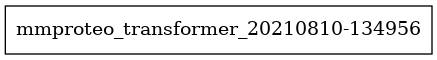

In [107]:
tf.keras.utils.plot_model(
    model=model,
    to_file=os.path.join(MODEL_PATH, "model.png"),
    show_shapes=True,
    expand_nested=True,
)

In [108]:
with open(os.path.join(MODEL_PATH, "summary.txt"), 'w') as file:
    def write_lines(line: str) -> None:
        file.write(line)
        file.write("\n")


    model.summary(print_fn=write_lines)
model.summary()

Model: "mmproteo_transformer_20210810-134956"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
on_device_embedding_1 (OnDev multiple                  11264     
_________________________________________________________________
transformer_encoder_1 (Trans multiple                  18903040  
_________________________________________________________________
transformer_decoder_1 (Trans multiple                  25200640  
_________________________________________________________________
relative_position_embedding_ multiple                  0         
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0         
_________________________________________________________________
dropout_3 (Dropout)          multiple                  0         
Total params: 44,114,944
Trainable params: 44,114,944
Non-trainable params: 0
__________________

In [109]:
try:
    with open(os.path.join(MODEL_PATH, "model.json"), 'w') as file:
        file.write(model.to_json())

    with open(os.path.join(MODEL_PATH, "model.yaml"), 'w') as file:
        file.write(model.to_yaml())
except NotImplementedError as e:
    print("not implemented")

not implemented


## Training the Tensorflow Model

In [110]:
model.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 1e-05,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.98,
 'epsilon': 1e-09,
 'amsgrad': False}

In [111]:
decode_idx: Callable[[np.ndarray], np.ndarray] = np.vectorize(idx_to_char.get)

evaluator = evaluation.SequenceEvaluator(
    dataset=datasets[EVAL_TYPE],
    decode_func=decode_idx,
    batch_size=BATCH_SIZE,
    separator=" ",
    padding_character=PROCESSING_INFO['padding_characters'][SEQ],
)

In [112]:
callback_list = callbacks.create_callbacks(
            tensorboard=True,
            progressbar=False,
            reduce_lr=False,
            early_stopping=False,
            checkpoints=True,
            csv=False,
            base_path=MODEL_PATH,
)

In [113]:
WARMUP_STEPS = 3000
STEPS_PER_EPOCH = 200

In [114]:
last_model = None

learning_rate = 10**-6
slowing_factor = 1

first_epoch = 1

while True:
    error_count = 0
    training_dataset = datasets[TRAINING_TYPE].repeat()
    validation_dataset = datasets[TEST_TYPE].repeat()
    
    aborted = False
    
    for epoch in range(first_epoch, 60):
        logger.info(f"epoch {epoch}:")
        learning_rate = EMBEDDING_WIDTH**-0.5 * min((epoch * STEPS_PER_EPOCH)**-0.5, (epoch * STEPS_PER_EPOCH) * WARMUP_STEPS**-1.5) / slowing_factor
        tf.keras.backend.set_value(model.optimizer.learning_rate, learning_rate)
        logger.debug(str(model.optimizer.get_config()))

        try:
            history = model.fit(
                x=training_dataset,
                validation_data=validation_dataset,
                validation_steps=STEPS_PER_EPOCH//5,
                epochs=epoch,
                steps_per_epoch=STEPS_PER_EPOCH,
                callbacks=callback_list,
                initial_epoch=epoch-1,
            )
            logger.debug(str(history.history))
        except tf.errors.InvalidArgumentError as e:
            logger.warning(f"Training error: {e}")
            error_count += 1
            if error_count > 10:
                logger.warning("abort training, because of too many NaN loss results")
                break

        eval_df, (x_eval, y_eval, y_pred) = evaluator.evaluate_model_visually(
            model=model,
            sample_size=20,
            keep_separator=True,
        )
        display(eval_df)
    else:
        aborted = True
    
    if not aborted:
        break
    
    last_model = model
    model = create_model()
    learning_rate *= 0.5
    slowing_factor *= 2
    first_epoch = 1
    break

2021-08-10 13:50:03,455 - mmproteo_attention_model: epoch 1:
2021-08-10 13:50:03,461 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 5.3791435e-05, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


INFO:tensorflow:batch_all_reduce: 185 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 185 all-reduces with algorithm = nccl, num_packs = 1
200/200 [==============================] - 203s 934ms/step - loss: 1.6493 - sparse_categorical_accuracy: 0.5197 - val_loss: 1.4985 - val_sparse_categorical_accuracy: 0.5402


2021-08-10 13:53:29,821 - mmproteo_attention_model: DEBUG: {'loss': [1.4789999723434448], 'sparse_categorical_accuracy': [0.5512040853500366], 'val_loss': [1.4984534978866577], 'val_sparse_categorical_accuracy': [0.5402278900146484]}


,predicted,true
0,A L A Q A A A A A A A A A A A L A A A R A R L A A R R,S I D E V F A R N M P I R E V E I I D T L L P G L K
1,L E I L S E E E L E E L A S V L L L L A K K L L P _ _,G L G E I A G A M V E E V P S A V D S L A D P E D R
2,L L L L S L L L L L L L R R R R R _,Y V K R S D L Q L V L G L V T S K
3,A A L E E A G A A A A A A A A A A A A A A A A A A,F S S S T A N R G P C P R V Q E A R P G D L G K
4,L L L E A A A A A E E A E L A E V _,T V S E V F E V A G D V P E R A R
5,L L L L L L L L L A L A L L L R R _,E G L C K E T L N Y L E L E D K K
6,R R R R R E L L L R L L A R R R R _,L L D L L A F M L P Y Y Q R E G K
7,L G L L G A G S G D G G R R R R R _,L F A G A K E V S T V D A Y R E K
8,L L L L V E L L A E L A K K K K _ _ _ _ _ _ _ _ _ _ _,A F I T H L H G D H I L G L P G L L Q T M D F N D R
9,L L P L P G P P P V P S S P S P K _,H G T E Q Q H R E A N G T K G E R


2021-08-10 13:53:31,723 - mmproteo_attention_model: epoch 2:
2021-08-10 13:53:31,726 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.00010758287, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 2/2
200/200 [==============================] - 184s 918ms/step - loss: 1.3644 - sparse_categorical_accuracy: 0.5773 - val_loss: 1.5032 - val_sparse_categorical_accuracy: 0.5386


2021-08-10 13:56:39,866 - mmproteo_attention_model: DEBUG: {'loss': [1.3643865585327148], 'sparse_categorical_accuracy': [0.5773137807846069], 'val_loss': [1.5031657218933105], 'val_sparse_categorical_accuracy': [0.5385937690734863]}


,predicted,true
0,L L L L L L L L L L L L L L L L K _ _ _ _ _ _ _ _ _ _,T M D L V L E M C N T N S I H W C G I S G R Q L G K
1,L L L L L L L L L L L L V V V V R _ _ _ _ _ _ _ _ _ _,L L N D Y S G R P T A L T F A D Q L T K Q L G G A K
2,L L L R R R R L A L L L A A A A K _ _ _ _ _ _ _ _ _ _,Y Y Q E K Y R Y I L I D E Y Q D T N V V Q Y L W A R
3,R G R R R R R R R R R L A A L A K _,A T D V A P N R L T A A Q E A A K
4,L L L L G G G G G G G G G G G G R _,A V A E D R L H Q D A G E P D T K
5,L L L L L L L L L L L L R L L L K _ _ _ _ _ _ _ _,M A F P N T S A Q Q A E T N R K I L E E I Q T K
6,L L L L L L L L L L L L L L L L R _ _ _ _ _ _ _ _ _ _,F E D L N L A G T A E V G L A G Y F M D H S V A F R
7,A L P L P P P P P P L P E E A P R _,L V V Y I G I A V A I M V E L A K
8,L S S L L S S S S S S S S S S S K _,E T I V G K V V P S A V E K G L K
9,L L L E L E L L E A A L E E A E E E E E E E E E E E E,Y N I N Q I S D Q M F F L P S L I N H N C E P N V R


2021-08-10 13:56:41,547 - mmproteo_attention_model: epoch 3:
2021-08-10 13:56:41,550 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.00016137431, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 3/3
200/200 [==============================] - 184s 917ms/step - loss: 1.2293 - sparse_categorical_accuracy: 0.6147 - val_loss: 1.4780 - val_sparse_categorical_accuracy: 0.5627


2021-08-10 13:59:49,139 - mmproteo_attention_model: DEBUG: {'loss': [1.2293314933776855], 'sparse_categorical_accuracy': [0.6146790385246277], 'val_loss': [1.4779858589172363], 'val_sparse_categorical_accuracy': [0.5626757740974426]}


,predicted,true
0,D A D D L A L K L L L L L L G K K _,F T E Y K P Y I E Q F N N R I K K
1,G G K A A A A A A A A T R _ T T R _,Q Y F V P G L A R P R F P P W D R
2,G S G S S A G S A A L R L S A A R _,F I T Y T L F R E S C R T V D G K
3,F L L L L L L L L L L L L L L L L L L L L L L L L L E,G I L N N N I T S S L F E L L E K N N I P T H F E K
4,S L D L L L D L D D E E L L L A K _,C A I I I Q S Y Y R M H V Q Q K K
5,E R R L L L L A L L L L A A A Y R _,L R I D D N W F R V D L L F F H R
6,T M A A A A L A A A A A L A L L R _,T V Q A L I E E L E K R A R P V K
7,G A L D L L L L L L L L L L E L L L L K K L L E L E K,L F Y Y C E Y N E V E N S C R V S L F K Q G I S Y K
8,V L A L L L A L L L L L L L L L R _,L T E E I T Y G R S K H H T L L K
9,N E L L L L L L L L L L L L L L L L,G L T A A S L G Q L L S S R G L R


2021-08-10 13:59:50,818 - mmproteo_attention_model: epoch 4:
2021-08-10 13:59:50,821 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.00021516574, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 4/4
200/200 [==============================] - 184s 917ms/step - loss: 1.1313 - sparse_categorical_accuracy: 0.6427 - val_loss: 1.4315 - val_sparse_categorical_accuracy: 0.5833


2021-08-10 14:02:58,392 - mmproteo_attention_model: DEBUG: {'loss': [1.131331443786621], 'sparse_categorical_accuracy': [0.6427119374275208], 'val_loss': [1.431509017944336], 'val_sparse_categorical_accuracy': [0.5833398699760437]}


,predicted,true
0,A N D P R R L R R R R L R R P D K _,S A S Y V R E R D Q I E N L A L K
1,D V D P D D P A P P A P P P P P P P,L V P D L V T E M G P A Y P E L K
2,E Q L L E L L E E E E E E E K V K _ _ _ _ _ _ _ _ _ _,Q D K E A Q S A V T A Y R P L A K V E L P I A T G K
3,N V I I I N N N S N N N N D N D K _,N A A P D L R G A G L D N A V G K
4,T Q A P P S S P S G P P P S S P S S,E D I P F L I N H F L E T F N H K
5,Q G W L R R R R R R R W W L L W K _,Y I E P D L A G K L A E P A R G K
6,A A D D A A A P A A A A A A A V R _ _ _ _ _ _ _ _ _ _,S L E S F V G R N F S G T S S G A E A A S N P L D R
7,M F A L V G A L G G G G A G G G G G,A H L V C H H R L H T G E K P Y K
8,G P E P P P P P P P P E E E E E R _ _ _ _ _ _ _ _ _ _,D M L A V A C V N Q W E Q L R G P G G N E D G P Q K
9,D D P L G V A A A G G G G A G R A R,G I V S F E L I D V R D F S K D K


2021-08-10 14:03:00,049 - mmproteo_attention_model: epoch 5:
2021-08-10 14:03:00,052 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.00026895717, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 5/5
200/200 [==============================] - 184s 917ms/step - loss: 1.0735 - sparse_categorical_accuracy: 0.6592 - val_loss: 1.4980 - val_sparse_categorical_accuracy: 0.5879


2021-08-10 14:06:07,504 - mmproteo_attention_model: DEBUG: {'loss': [1.0734962224960327], 'sparse_categorical_accuracy': [0.659208357334137], 'val_loss': [1.4980247020721436], 'val_sparse_categorical_accuracy': [0.5878971219062805]}


,predicted,true
0,N L T L K K K K K K L L A V V F K _,F L N E I L Q A E L E P I R N R R
1,E K L A L L L P E E L E E E V R K _,M L E R D L Q L L C L T G V E D R
2,E E S E L V V V L E E L E V V D R _ _ _ _ _ _ _ _ _ _,K L M D V T Q N I G I D L F I G I G A F N A A Y T R
3,D E D L K K L L L L K L E E G Q K _,M Q K E Y L K H Y H E L N P S E Q
4,L V Y R L S L L E L S S S S S S K _,K A P D C L I K L L N Q M Q L F R
5,F F K H H H V A A L L L A P L P S S,L L W Q S G T C V A R F Q S S V R
6,D V A E A A A A A A A A A P R A K _,I L A K N D Q M D L V D Q I D Q R
7,R V N K P L L P P P P S S S S K K _ _ _ _ _ _ _ _ _ _,E S T H I K G F E E E V F W V T K G G S T D L D V K
8,E E D L L E E E E E E E S E E S D E S S P S D E D,V E E A Y N F V R E L A A N G G K I L F V G T K
9,A A S R R R L L A A E A E E E A A A,L E T A E E F S G W L R L Y A D R


2021-08-10 14:06:09,157 - mmproteo_attention_model: epoch 6:
2021-08-10 14:06:09,160 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.00032274862, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 6/6
200/200 [==============================] - 184s 917ms/step - loss: 1.0011 - sparse_categorical_accuracy: 0.6804 - val_loss: 1.4502 - val_sparse_categorical_accuracy: 0.5989


2021-08-10 14:09:16,713 - mmproteo_attention_model: DEBUG: {'loss': [1.0010550022125244], 'sparse_categorical_accuracy': [0.6803619861602783], 'val_loss': [1.4501882791519165], 'val_sparse_categorical_accuracy': [0.5989453196525574]}


,predicted,true
0,C C H H L H A H A A A A A A G Q R _ _ _ _ _ _ _ _ _ _,D N V D K I Q Y N I T K T I Q N C E F A D E I I A K
1,A A C W D D L L L L L D P S Y S R _ _ _ _ _ _ _ _ _ _,I D D G L E K R T I V S G I A Q H Y K P E E L V G K
2,G H L E L L L L P L L L S A G F K _ _ _ _ _ _ _ _ _ _,V N I T D S F L I G Y V H I Q Q Q A K N F T I F E K
3,D E S S E E L V K K E E E E N L K _,C D Q C K D H Y F G F D P Q T G R
4,M S Y L E K K K K K K K L L Q S K _,W M E L G K G E W I L E L L L E R
5,G G Y S A L L L L L L L L L L L L L L L L L L S G S C,S H Y C G S V N E S H L D Q E V T L C G W V N R R R
6,Q Q D T E E L E K K K R R L L L K _,D G G F I A S N W E L Y K A Q V R
7,L L H L E E L E L L L L L L L Y K _,I K P T D I T E E I S K D V L Q K
8,S S F D E E L L E L V E E E V E R _,M H K Y G N V K I L S T M P H V R
9,S A L E L L P E E E L G G P G S K _,L I V A I A D P T S Y I K S G S K


2021-08-10 14:09:18,528 - mmproteo_attention_model: epoch 7:
2021-08-10 14:09:18,530 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.00037654006, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 7/7
200/200 [==============================] - 184s 917ms/step - loss: 0.9143 - sparse_categorical_accuracy: 0.7067 - val_loss: 1.4803 - val_sparse_categorical_accuracy: 0.6176


2021-08-10 14:12:26,042 - mmproteo_attention_model: DEBUG: {'loss': [0.9143425822257996], 'sparse_categorical_accuracy': [0.706697940826416], 'val_loss': [1.4803218841552734], 'val_sparse_categorical_accuracy': [0.6175813674926758]}


,predicted,true
0,E V G L G V G P V L L G V G A F K _,E Q F D S A H Q A L R E H P E V K
1,I Q Q E E L L L L L E E E K R K K _ _ _ _ _ _ _ _ _ _,G A K Q T F E E M M N Y I P D L I V K C I G E E T K
2,V V V E D L D L P P L L D P L H K _,L Q A I K L Q T N L S A G R R P R
3,T N K P T R R R R R R R L E I P K _,Q Y A T L L S G L A A A G D E E K
4,D D E D R R R R L L G V G R P L G V,I S G H Y V H Y S E D M F P S V K
5,E H H H L L L L L L L L D L Q T R _,L S H H E V L L R L D G Y D P E R
6,C C F K S G E G G G G L D G G V R _,G E V S D W V N Y L S P S Q V E R
7,W Q S G H H H H H H A L L L G L L A,L P L Y Y R F I N N L N Q Q G K K
8,K S P P D P P L L L L D D P R G R _,D D L P A Y L N D E P P A D A N K
9,F A P G K K K K P P A G D D S P R _ _ _ _ _ _ _ _ _ _,I R A N H S A T H L L H E A L R E V L G T H V A Q K


2021-08-10 14:12:27,929 - mmproteo_attention_model: epoch 8:
2021-08-10 14:12:27,932 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.00043033148, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 8/8
200/200 [==============================] - 184s 917ms/step - loss: 0.8111 - sparse_categorical_accuracy: 0.7387 - val_loss: 1.4472 - val_sparse_categorical_accuracy: 0.6441


2021-08-10 14:15:35,515 - mmproteo_attention_model: DEBUG: {'loss': [0.811145007610321], 'sparse_categorical_accuracy': [0.7387399077415466], 'val_loss': [1.4471791982650757], 'val_sparse_categorical_accuracy': [0.6441015601158142]}


,predicted,true
0,Q L F N E H H H H H K K D L L T R _,H E A A V P P L A V S S T R P E K
1,Y H R D L L L L S G A S G D L Q K _ _ _ _ _ _ _ _ _ _,G P A A D A A K E A G A E V V G M E D L A D E V K K
2,E L F T L L L L R R L R R G H W R _,L C Q L Q L N E I K T S D D P T K
3,A P L Y D L R R R R R R L R F L R _ _ _ _ _ _ _ _ _ _,A Y Y T T E I P E D R F E A L S C I K D S Q K P L K
4,C K D F G L S I S S G R R S Q F K _ _ _ _ _ _ _ _ _ _,L P A T I I L R A L E F T T E E I L T T F F E T I K
5,L T L E D A A R L R L L A R V A R _,D L C Y V D P D P N L D A A A R R
6,Y Y G V R R R R R R R K S N A L K _,T Y F I K H A L S S K Q T I D G K
7,S Y A L S L L D G G G G G R R R G A,A G Y H Y T S T P E R P W L C S R
8,M D P L A T L K K D G A D S H E K _,K L I T E V V L L V P V L H L L R
9,L A R Q S S A A L L A A A S A E S T,E I A S G H V G V E M L K K V P V


2021-08-10 14:15:37,261 - mmproteo_attention_model: epoch 9:
2021-08-10 14:15:37,264 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.00048412292, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 9/9
200/200 [==============================] - 184s 916ms/step - loss: 0.6892 - sparse_categorical_accuracy: 0.7764 - val_loss: 1.4511 - val_sparse_categorical_accuracy: 0.6561


2021-08-10 14:18:44,807 - mmproteo_attention_model: DEBUG: {'loss': [0.6891573071479797], 'sparse_categorical_accuracy': [0.7763736844062805], 'val_loss': [1.4510555267333984], 'val_sparse_categorical_accuracy': [0.6561197638511658]}


,predicted,true
0,G M D E T F G F S T D G R G R A R _,L L Y L I S E G N W F P N T L D K
1,C C G L G F S S L R R R R L G R R _,A V L L T P E K E V E P G T R V C
2,M N N G P M R R L L R L R R G K R _ _ _ _ _ _ _ _ _ _,A I G F T R D E D I L G L F D L V E E V P M K A A K
3,N V L V A F P P G A G G G G G R P R,S Y F I N N V A E K V S S Q I R K
4,S S S C S Y S L I S S Y K R T E K _,R R A Y S T N Q I T N H K P L P R
5,D A L A Q L A N E E R R R F Y G R _ _ _ _ _ _ _ _ _ _,S N F I V G F P G E S E A D L A E L E R F L N H A R
6,V I K L G I I A L I I A T F S S K _,N I D T G A G L E R V A S V V Q K
7,V P D T M D Y F I S Y I I I P P S P,Y C I D V L T Q I S A V T S A L R
8,R V H H A E A E L L L L V L A G A E,I E C R T G A S L Y E M S A P I K
9,V P L L L V L L L K L R K P R S R _,L V K L M N G E V E Y I R E A G K


2021-08-10 14:18:46,443 - mmproteo_attention_model: epoch 10:
2021-08-10 14:18:46,445 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.00053791434, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 10/10
200/200 [==============================] - 184s 916ms/step - loss: 0.5764 - sparse_categorical_accuracy: 0.8110 - val_loss: 1.3069 - val_sparse_categorical_accuracy: 0.6886


2021-08-10 14:21:53,830 - mmproteo_attention_model: DEBUG: {'loss': [0.576404333114624], 'sparse_categorical_accuracy': [0.8110074996948242], 'val_loss': [1.3069454431533813], 'val_sparse_categorical_accuracy': [0.6886067986488342]}


,predicted,true
0,A T M V K N A T T T A A D K M S K _,V H A L Q M D V L K L T Q A H E R
1,N E N A T P S E D D N F E E A I K _ _ _ _ _ _ _ _,S S V L N C L M P H L A L R V G A V S G R L Q R
2,V V S A Y Q Y G I S A I K L A I K _ _ _ _ _ _ _ _,E I D N I Y D L G F W D N L R E V F H M P I R R
3,G G R G A L G V G G D A A G D A L _ _ _ _ _ _ _ _,G M D I A E A V E I A I K N G V T V V Q L R E K
4,D N V L G L F H H H H P R T A L R _,D W L Q P N I F Q P T D E G T R K
5,E E G Q L E D V D P P L L R R R L L D A H L V D D,N T E G R L N I I N P E D F E N C G I E I F V K
6,M V E D Y K K V F S D F I D F V K _,S A N Q A H Q N E W L E N F F C R
7,G G N D I Q L E S P E S E E L F D Y,E A V V L N P P P A D R G R P L K
8,R S A L A K S Q I P L D V V P L R _,I A V D V K T A S L W S N H A E R
9,R S R R P G A E E Y L E E E E A W E,F W P W Q R H I N P H Y S A C K K


2021-08-10 14:21:55,510 - mmproteo_attention_model: epoch 11:
2021-08-10 14:21:55,512 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.0005917058, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 11/11
200/200 [==============================] - 184s 916ms/step - loss: 0.4883 - sparse_categorical_accuracy: 0.8379 - val_loss: 1.3060 - val_sparse_categorical_accuracy: 0.6997


2021-08-10 14:25:02,915 - mmproteo_attention_model: DEBUG: {'loss': [0.48825928568840027], 'sparse_categorical_accuracy': [0.8379420638084412], 'val_loss': [1.3060449361801147], 'val_sparse_categorical_accuracy': [0.6996549367904663]}


,predicted,true
0,L R L L E D V L H L L R R L L L L D,F G I S S R F D Y Y P P E L L E R
1,Y Y T Q A V P P E E S V L D T T R _,E K P V P E E A A K L C A E E I K
2,D R L G R A A A L A S G P Q Q Q R _ _ _ _ _ _ _ _ _ _,H M G I R P T V R G S V M N P N D H P H G G G E G R
3,F M M E R R S A G K S A P D F P K _,I I Q V D G N F D D C L E L A R K
4,E T P G V S E Y S L G H S L V A R _,N V T I S K N Q G T A Y F I N N K
5,F N G C K L L Y F S S D E C Y E K _,C N Y F P D L G N C L E C E T S R
6,S G E V T V N E Q V K K S G A V K _ _ _ _ _ _ _ _ _ _,E R V E L K M D L P G V S I A D E G E T G M F S L R
7,C S T P P Y V P M P P F K P G E K _ _ _ _ _ _ _ _,T L A A A L K V Q P A D V L G R V E A L L D E R
8,A Q K G Q D M N L E Q W T V G G R _ _ _ _ _ _ _ _,T L M L R S N L I S C V N N D T F A G L S S V R
9,E K S N L S P P R R V Y A M A T R _,L H I P D D V V I M A K N V H S K


2021-08-10 14:25:04,690 - mmproteo_attention_model: epoch 12:
2021-08-10 14:25:04,693 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.00064549723, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 12/12
200/200 [==============================] - 184s 916ms/step - loss: 0.4166 - sparse_categorical_accuracy: 0.8599 - val_loss: 1.1914 - val_sparse_categorical_accuracy: 0.7291


2021-08-10 14:28:12,313 - mmproteo_attention_model: DEBUG: {'loss': [0.41661834716796875], 'sparse_categorical_accuracy': [0.8598623275756836], 'val_loss': [1.1913634538650513], 'val_sparse_categorical_accuracy': [0.7290918231010437]}


,predicted,true
0,S A F N N A A D P L E K L E L H R _,I L S V C W P L Y D Q G S D N L K
1,E Y D T E Y F E V P L L P P L T T _,S Y P T D I N H I I S S E G M G K
2,K G S L T V G V H H S S F P F L K _,N Q P V V N A K A T F H N V A T K
3,Q L A A E M S H E L K S P N P F K _ _ _ _ _ _ _ _ _ _,R V A M L V V M M L V M G N M L I E A E A V M S F K
4,L P W Y I I A G C V P A A L V G K _ _ _ _ _ _ _ _ _ _,D C V D T V I T N A L I V D H W G I V K A D I G L K
5,A P T G V F A H G F L T V D G K K _,L V P Q Y K V T V L S F Q L L L K
6,M E L I K K S A K S T L L K P K I Q,T G A N F F N V E A Q V R D R L K
7,E W G L T S L P L P P P P T G L K _ _ _ _ _ _ _ _,M S K Y A D R L I Q Y I E E H P D F I Q P E S R
8,G A S G L L L Q S K A S R F M H R _,I A V V V S M Q A S Q L F T S S K
9,N K H M K P C H F T S G L E E L K _,H L N T S D N V N N M K T N N L R


2021-08-10 14:28:13,922 - mmproteo_attention_model: epoch 13:
2021-08-10 14:28:13,927 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.0006992887, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 13/13
200/200 [==============================] - 184s 917ms/step - loss: 0.3553 - sparse_categorical_accuracy: 0.8788 - val_loss: 1.0111 - val_sparse_categorical_accuracy: 0.7655


2021-08-10 14:31:21,399 - mmproteo_attention_model: DEBUG: {'loss': [0.355315625667572], 'sparse_categorical_accuracy': [0.8787747621536255], 'val_loss': [1.0110975503921509], 'val_sparse_categorical_accuracy': [0.7654980421066284]}


,predicted,true
0,T D P G T S E V R A A D P P V Q N P,M Y E F A D K L M S I A L P R V R
1,V P N E G L L L E G V L I P A V L _,V Q G L I I S Q M L R K S V E T R
2,M D E A L R R Q L A A L F D L Y Y F V M P T F G A,L E E A T N W A Y E N A L D V I A L G F S P E R
3,E I Y G Y L K V I K A Q V Y V V Y E,A G K E V G K A V G G A L G A G K
4,K I L D A L N L E L V F L D F F T S E I K _ S A S E L,R N D T A G S G L I P V N G S D R T N I N P F C S K
5,M E L Y E D A R R K V E T N P L R _,I L L E Y Q I D T I V I G L P I K
6,S E R L F G H L E R G A Q L S S K _,S D A G V S V P A G G I E Q E L K
7,D E D N R N V V V G D P S P C G K _ _ _ _ _ _ _ _ _ _,G R E N A I R N G L H N V T F F H E N L E E D V T K
8,D W V S N V Q E T F F F A A S P P D,N K E H E I E V I D Q R L I E A R
9,G A K M M D L N Y P G G P E L A R _,I A E Q L K I S P A A V T K A L K


2021-08-10 14:31:23,069 - mmproteo_attention_model: epoch 14:
2021-08-10 14:31:23,071 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.0007530801, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 14/14
200/200 [==============================] - 184s 917ms/step - loss: 0.2994 - sparse_categorical_accuracy: 0.8962 - val_loss: 0.8373 - val_sparse_categorical_accuracy: 0.7877


2021-08-10 14:34:30,698 - mmproteo_attention_model: DEBUG: {'loss': [0.29943370819091797], 'sparse_categorical_accuracy': [0.8962024450302124], 'val_loss': [0.8373295068740845], 'val_sparse_categorical_accuracy': [0.7876660227775574]}


,predicted,true
0,L E N E K K R P S S W N M L S S K _,A V L I H T W V G R F F M N T M K
1,N S A E K L M A G S L L G T R R D R P G A A L T E _ _,R T Q A A G D S D A E D G N A G D L D F F G S G K R
2,M H V V A W P E Y H H A A F A E G E,V V N E N G V T L K K P H Y F N R
3,W L E G N G L R F I A A N A R E R _,K N P C T N C E Q A G E K C M F K
4,Y F D V R V R R P E A T A I I M K _,E D H C E E T Q P V L K R I Q L K
5,T T L A M T S P G H D I H H H Y R E G G G L L Q R S F,H F E M G C Y G I G V T R I L G A A I E Q N H D E R
6,G K D L R V L A L L E S S G C D K _,L L I D L K D Y E D A Y R A L V K
7,E T Q V D L G L H H K H L G I A F F,Q E Q Q A V S E A A E P V D P R K
8,G L E K P R N A L V S Q W E E W W P,G E Y F S W L S H D D I Y Y P N K
9,E A K D L V E K A G T P D A V V K _,K P I I P T P Q E I A Q N K R S R


2021-08-10 14:34:32,336 - mmproteo_attention_model: epoch 15:
2021-08-10 14:34:32,339 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.0008068715, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 15/15
200/200 [==============================] - 184s 916ms/step - loss: 0.2762 - sparse_categorical_accuracy: 0.9030 - val_loss: 0.8697 - val_sparse_categorical_accuracy: 0.7977


2021-08-10 14:37:39,908 - mmproteo_attention_model: DEBUG: {'loss': [0.27624988555908203], 'sparse_categorical_accuracy': [0.9030410051345825], 'val_loss': [0.8696700930595398], 'val_sparse_categorical_accuracy': [0.7977343797683716]}


,predicted,true
0,M W W R H T T V P P H M V H H G L G A A A A V H D _ _,T N K P F I L H D G P P Y A N G D L H I G H A L N K
1,L L D T V R Q L A V K T G V L P R _,S T S P C Q T P E P D N E A H I R
2,K P S I E L P P F E I P A G A A A L,A I S F K R Q I V A G T N L F I K
3,Q N S M M R S S A S S S S S S S R _ _ _ _ _ _ _ _ _ _,I V E G A T F E R L R A A L N G Q V V D G G A G L K
4,T N I G L V I E C S G A N L A I K _ _ _ _ _ _ _ _ _ _,D M V E I L K N L Q L E E S S V L I A L P E K D E K
5,A K T P R E D A G A K V N D A P K _,M E N L F E L H A D V R V E Q G K
6,C L Q Q G Q S L L K T P R G E L R _ _ _ _ _ _ _ _ _ _,R V V L V P V P A Q G H I T P M I Q L A K A L H S K
7,N S I F F L A G F F G Y G F G H F G F G V V P E S A G,V I E E K L G P E D L H R P Y V D A F I I K V N G K
8,D D N C S E P L V H F L S Q I E R _,I T E E G V E F R S H L D G S K K
9,M T A L M G L S A A L A N D G K R _,G L L I T N P S N P L G T I M D R


2021-08-10 14:37:41,564 - mmproteo_attention_model: epoch 16:
2021-08-10 14:37:41,567 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.00078125, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 16/16
200/200 [==============================] - 184s 917ms/step - loss: 0.2452 - sparse_categorical_accuracy: 0.9125 - val_loss: 0.7400 - val_sparse_categorical_accuracy: 0.8192


2021-08-10 14:40:49,228 - mmproteo_attention_model: DEBUG: {'loss': [0.2452138513326645], 'sparse_categorical_accuracy': [0.9124671220779419], 'val_loss': [0.7400000095367432], 'val_sparse_categorical_accuracy': [0.8191894292831421]}


,predicted,true
0,V L A F Q A E T L D Q K G A T P R _,D S L L E D D Q S C P H P K Q P R
1,Q G Q P P Q Q F L V D I A A G R R _ _ _ _ _ _ _ _ _ _,H V R P S Q S H P Q G A I I E R E F P I H A S N V K
2,H Q P E S E E K P V L T D L S Y R _ _ _ _ _ _ _ _ _ _,K L M E A G W P E G V L L N L N F P N C G A D E V K
3,N N F H L S V S S A L A K E T L G V,E L E V K P K L R P L H D Y I E K
4,D S N Y P P P P K P E L L Q G L R _,L L V Y K Q Y Q E I V P K L M E K
5,E G W D V A L K A D A E Y P T W V S N G E W V L A,Q D M P Y L Q D G T P V D M I L S P L G V P S R
6,E N E Q F F C Q Q D Q M F L A D R _ _ _ _ _ _ _ _ _ _,N L N Y E D I E E E I L K K V S I N P D L S T Y S K
7,N N C V M P Q D I K N C F L C S N G,V I I E V L S E S T E G F D R G K
8,Q G L C G Q A L L L T P Q D F H H _,M L T I N S I K N G I V I D H I K
9,N N R D D E E D D D H D G D S S S S,Y Q P G L F L S S F F T T L E S R


2021-08-10 14:40:51,095 - mmproteo_attention_model: epoch 17:
2021-08-10 14:40:51,097 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.0007579238, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 17/17
200/200 [==============================] - 184s 918ms/step - loss: 0.2183 - sparse_categorical_accuracy: 0.9209 - val_loss: 0.6839 - val_sparse_categorical_accuracy: 0.8352


2021-08-10 14:43:59,102 - mmproteo_attention_model: DEBUG: {'loss': [0.21834604442119598], 'sparse_categorical_accuracy': [0.9209410548210144], 'val_loss': [0.6839269399642944], 'val_sparse_categorical_accuracy': [0.8351790308952332]}


,predicted,true
0,D G Q Y V A T S S S S S S S E V E V,L P V Y H V T I L V K D Q K G L R
1,Y Y P L N A T L W W L N W F F G R _ _ _ _ _ _ _ _ _ _,M E N R T Y T A D A E P G E T V T V A G W V H E V R
2,K H E I P F I F F T Y Y N L T F K _,Q L G Q F Y G L M S R T A Q V R R
3,L L E S L G A E V E F N N E F N Y T N G L K K A H,G V T D S S S S R Q D T V L V G A Y L P E P W K
4,E Q D I A F Q P D T G S V P E Q R _,D D Y Q L N D R N V T K G D I V R
5,V V M T N N I Y G Y D W T L P Y T W W L R T D G T _ _,S L E S I N N T I E S T K T M L L D P E M H D L A K
6,E C Y A N I G V V V Q G E N R T R I I Q G _ C F G,K N P M T N Y S T I P T A V M D H S I S A F M R
7,S S T F T L W C L T S L T D G V T M F F D D D D T F T,S T L M K V L C G I Y P S G D Y E G E I Y F S G E K
8,A T L N V E F Y P V L V G S A F K _ _ _ _ _ _ _ _,D H V D L G E S L G L L D F N S G A K L A G S R
9,V E M Q E R A Y E E D E D L L N K _,M F V C S D T D Y C R Q Q S E A K


2021-08-10 14:44:00,913 - mmproteo_attention_model: epoch 18:
2021-08-10 14:44:00,916 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.0007365696, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 18/18
200/200 [==============================] - 184s 918ms/step - loss: 0.1970 - sparse_categorical_accuracy: 0.9280 - val_loss: 0.5737 - val_sparse_categorical_accuracy: 0.8504


2021-08-10 14:47:08,653 - mmproteo_attention_model: DEBUG: {'loss': [0.19702289998531342], 'sparse_categorical_accuracy': [0.9279671311378479], 'val_loss': [0.5737229585647583], 'val_sparse_categorical_accuracy': [0.8504427075386047]}


,predicted,true
0,S S A W Y E P S P N L V K K S S R _,K P E S M D F K G V R G L Q G V K
1,N N K Q L M Q Q L I D T C K G H V _ _ _ _ _ _ _ _ _ _,Q A A A A V K V S M G D T V V L V A V T T N K E V K
2,M D R I G N A S G L G C N N G R _ _,L V A D A E D V L R R L E L P Y R
3,L E F G L D D N G V L T L M D E E L,S Q W D T P N K I I A K V E Q A Q
4,S E M E H L R R N A A L A Y L M K _ _ _ _ _ _ _ _ _ _,E V E D G G M L S Q G R C S I F L P E P A E E P P R
5,D D H K L D S K L V S T N L I Q R _,E L M Q K F A P V A L A T N V I R
6,S T T V P V Q V V G G G N R R V R _ _ _ _ _ _ _ _,V F N K A V V W Q K E H L D E A A D L Y S D I K
7,F Y L S Q D D S L R R L F A G D R _ _ _ _ _ _ _ _ _ _,S E P V K E E S S E L E Q P F A Q D T S S V G P D R
8,L L S D Q F G Y N L L Y F F Q L S D,Q M A A E Q E K V G A E F Q A L R
9,F K L A P G V D V N Y M V H T H R _,K P F K E S M T E S E L V Q A V K


2021-08-10 14:47:10,320 - mmproteo_attention_model: epoch 19:
2021-08-10 14:47:10,323 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.00071692414, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 19/19
200/200 [==============================] - 184s 918ms/step - loss: 0.1805 - sparse_categorical_accuracy: 0.9331 - val_loss: 0.6596 - val_sparse_categorical_accuracy: 0.8461


2021-08-10 14:50:18,362 - mmproteo_attention_model: DEBUG: {'loss': [0.18047961592674255], 'sparse_categorical_accuracy': [0.933139979839325], 'val_loss': [0.6596055030822754], 'val_sparse_categorical_accuracy': [0.8461295366287231]}


,predicted,true
0,D L S E E N V Y E D L L D P P M K _,I V H D E A E L A E S L K D A Y R
1,R L D E G K S V L R V P L T Q L K _,E L V H A G L C I P S S S L L V R
2,D Y L A T L P N Y P K E A L E F R _,Q G A H A G Y Y P G N S P L H L R
3,D Q E E I Q D Y D V Q E A L W G K _,L A S C L N T N S G S K I D A G K
4,Y K V F V D L F N L A T Y L V P R _,H A D D L G Y Q L K Q M K E D I R
5,V D S E A S S P P V T E D K S S G S,I I N R F I L T N A I N V L D V K
6,S L D N P Y Y Y S S E Y Y A H A Q L S F E E A A A,A Q L P P S A P A S L Q K G L A N I C T E L E K
7,N V P E L V S L N K N A F S G C G S,V F D S M G S K S I Y A S E I S R
8,E Y H S L G W V M K L H I G S L R _ _ _ _ _ _ _ _ _ _,I L L C N T Y H L G H R P G H E R V K A A G G L H K
9,K P K P V D V A I L S E V D G E V S,H A E Q E L S P G S S A V T G A R


2021-08-10 14:50:20,029 - mmproteo_attention_model: epoch 20:
2021-08-10 14:50:20,031 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.00069877127, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 20/20
200/200 [==============================] - 184s 917ms/step - loss: 0.1659 - sparse_categorical_accuracy: 0.9380 - val_loss: 0.5815 - val_sparse_categorical_accuracy: 0.8576


2021-08-10 14:53:27,548 - mmproteo_attention_model: DEBUG: {'loss': [0.16587139666080475], 'sparse_categorical_accuracy': [0.9380286335945129], 'val_loss': [0.5814893841743469], 'val_sparse_categorical_accuracy': [0.8576497435569763]}


,predicted,true
0,K C L A Q A N A S V S S D G N Y T D D L V F A D V _ _,E K E D R P F H Q A V V N D T Q A F W H N K Q A S K
1,S C G M L L A A E Y V D A A G T K _ _ _ _ _ _ _ _ _ _,E V I K S I E S Q E A K V C F L S D V C S E P A Y K
2,L L S R G L S H Q E G A L D M T E G L A A A A G P,K G Q P V L V G T I S I E T S E L I S S M L R K
3,M M L Y E M I A Q E V K T K K Y K _,L E S S Y Y R S L D A I Y F D A K
4,V V R A A I Q N L P T E W V H E K _,M L S P A N S L D I A M E K H Q K
5,D T T Y S F L L I T D N I I N L K _,H Y S S S N S S L K A Q F T V L K
6,M T Q I P A V E K Q E E H L R L R _,L D A R L K P M V L L V K H W A K
7,M G R R G N G L H G I A M T K L D V,S D D T H E N E A N M T P E E M K
8,D T A L S I K C T Q I V Q G L F K _ _ _ _ _ _ _ _ _ _,M S E A A G N L N S L R L A N V A L R E E L N A L R
9,F T I A A P S A T L Q T H V E R K _,L I L E A T S P D G M L I G F D R


2021-08-10 14:53:29,167 - mmproteo_attention_model: epoch 21:
2021-08-10 14:53:29,169 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.0006819309, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 21/21
200/200 [==============================] - 184s 917ms/step - loss: 0.1518 - sparse_categorical_accuracy: 0.9427 - val_loss: 0.5734 - val_sparse_categorical_accuracy: 0.8642


2021-08-10 14:56:36,775 - mmproteo_attention_model: DEBUG: {'loss': [0.15180319547653198], 'sparse_categorical_accuracy': [0.9426940083503723], 'val_loss': [0.5734114050865173], 'val_sparse_categorical_accuracy': [0.8642317652702332]}


,predicted,true
0,M V E G E V P E V W D T L E E V V K,C L I T D T L E H Y D L E D Y V K
1,A L A Q S H V Y L G I K P D E I K _,S F C M L S Q L T Q H K K I H I R
2,Y E Y P V K W G N D L K T E H E R _ _ _ _ _ _ _ _ _ _,H L V L T A P H P S P L S A H R G F F G C H H F S K
3,D S L L C S R M R S A A A A P P H G,I E T P L V E T D A P V L E G K K
4,E V S C C E N R A L A E E W G M M C M E T S S G G,I P Y Y G S L T Q T D P A I V A A E G V A K F K
5,D A K R S M R L L L L L S M L A K _,R V L D R I V G Y M I S P L L W R
6,N Q A T K S W N D V L N A E A A A E V S L L E E P A C,E Q G L L R G K L M V L F S G A D Q S V P A W V D K
7,A A I E E T L L I E F W T F I S R _ _ _ _ _ _ _ _ _ _,G Y N S N Y V P G W D C H G L P I E W K I E E K Y R
8,K S D G S I S F L V L G D W G R K _ _ _ _ _ _ _ _,D P A M S D Q A L A L Y I P A S A F P T Y A R R
9,R N S E E F G K K L G S Q I F L K _,S H G S S I N A A C G Q L A I N K


2021-08-10 14:56:38,578 - mmproteo_attention_model: epoch 22:
2021-08-10 14:56:38,580 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.0006662522, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 22/22
 94/200 [=============>................] - ETA: 1:34 - loss: 0.1407 - sparse_categorical_accuracy: 0.9466

KeyboardInterrupt: 

In [116]:
train_evaluator = evaluation.SequenceEvaluator(
    dataset=datasets['Train'],
    decode_func=decode_idx,
    batch_size=BATCH_SIZE,
    separator=" ",
    padding_character=PROCESSING_INFO['padding_characters'][SEQ],
)

In [117]:
train_evaluator.evaluate_model_visually(
    model=model,
    sample_size=20,
    keep_separator=True,
)

(                                                    predicted  \
 0                                             L N A I A Q R T   
 1                                 D G T R N G F D I N L L K _   
 2                                 L L N P L V S K L S E K R _   
 3                                             R L K S L A R _   
 4                                 L P A D G Y V Y Y L I G S D   
 5                         K N H K N E K _ _ _ _ _ _ _ _ _ _ _   
 6                                             S D S I T E K E   
 7                                 S S L A V K A G V C M K K _   
 8   T V F R T D A L H L S S R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _   
 9   M D Y L I P K L V T L Y D L F R K _ _ _ _ _ _ _ _ _ _ _ _   
 10                                            G L P C Y F V H   
 11                                E L K P E N L L L D A E G N   
 12  L L A S I G A R R A E A E A Q A A V M V T S H L G R P K _   
 13                                            N G Y L N E G Q   
 14       

## Evaluating the Tensorflow Model

In [121]:
train_evaluator.evaluate_model(model)

78/78 [==============================] - 23s 292ms/step - loss: 0.1382 - sparse_categorical_accuracy: 0.9475


[0.1381891816854477, 0.9474717974662781]

In [129]:
model.metrics

In [133]:
y_eval[0]

array([[13, 14, 19,  6,  5,  4,  9, 11, 16, 15, 19,  6, 14, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]],
      dtype=int32)

In [136]:
np.argmax(y_pred[0], axis=-1)

array([11, 19, 13,  4, 12, 17,  5,  9, 10,  2, 17, 17,  3,  9, 17, 12, 15,
        5,  3,  7,  3, 14, 17, 17, 12,  2,  3, 14, 20, 20])

In [150]:
y_eval[0][0].shape

(30,)

In [168]:
acc = tf.keras.metrics.SparseCategoricalAccuracy()
acc.update_state(np.array(y_eval).squeeze(), y_pred)
acc.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.27666667>

In [170]:
acc = tf.keras.metrics.Accuracy()
acc.update_state(np.array(y_eval).squeeze(), np.argmax(y_pred, axis=-1))
acc.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.27666667>

In [122]:
eval_df, (x_eval, y_eval, y_pred) = train_evaluator.evaluate_model_visually(
    model=model,
    sample_size=20,
    keep_separator=True,
)
eval_df

,predicted,true
0,N Y Q F P V G L M D V V E L,Q R Y H G F L N T S Y H R
1,E L G A K V L A,F S L R F R R
2,V L P A A E A V R E A D V N M V L L P D E L Q A Q V Y R _,K K G G L H T V V D S T T L S R P L Y A I W L Q N S D K
3,G N H N Y T C E S G V L K _ _ _ _ _,H N F Y K S M N E H D V I A E K K
4,G N V E Y W V A L I Q P G K,E M L H A R E V I A S L K
5,R G A E E E E V E E P L G V E K K _ _ _ _ _ _ _ _ _ _ _ _,N I L E S C L L L S S S T L G N T R D D W P T A E E R R
6,A A F F L E V H D T L Y D R H L R R,V P L V A S P V H L G P S Q P L K
7,N K H S S S E Q E P D S A S S S K _ _ _ _ _ _ _ _ _ _ _ _,D I L V E L G R R G M V G G Q E D M I E D T A M T M A R
8,G G T G D V L A G I L T A L I A K _,D A L Q T N N D I S R L H K E F K
9,D P T E F T G P E S Y V Y A,R E G M S G I E E K A L R


In [ ]:
eval_df.predicted.map(print)
None

broken loss function?

In [ ]:
np.argmax(y_pred[0], axis=1)

In [ ]:
datasets[EVAL_TYPE].take(1)

In [47]:
list(datasets[EVAL_TYPE].unbatch().batch(1).take(1).as_numpy_iterator())[0]

ValueError: Cannot unbatch an input whose components have different batch sizes.

In [ ]:
model.predict(datasets[EVAL_TYPE].unbatch().batch(1).take(1))

In [ ]:
y_pred.shape

In [ ]:
y_pred